In [11]:
import numpy as np 
from mnist import MNIST
import matplotlib.pyplot as plt
import scipy.misc
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import imageio

In [4]:
# This function visualizes filters in matrix A. Each column of A is a
# filter. We will reshape each column into a square image and visualizes
# on each cell of the visualization panel.
# All other parameters are optional, usually you do not need to worry
# about it.
# opt_normalize: whether we need to normalize the filter so that all of
# them can have similar contrast. Default value is true.
# opt_graycolor: whether we use gray as the heat map. Default is true.
# opt_colmajor: you can switch convention to row major for A. In that
# case, each row of A is a filter. Default value is false.
# source: https://github.com/tsaith/ufldl_tutorial
def display_network(A, m = -1, n = -1):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)
        

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0

    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1

    return image

In [3]:
def display_color_network(A):
    """
    # display receptive field(s) or basis vector(s) for image patches
    #
    # A         the basis, with patches as column vectors
    # In case the midpoint is not set at 0, we shift it dynamically
    :param A:
    :param file:
    :return:
    """
    if np.min(A) >= 0:
        A = A - np.mean(A)

    cols = np.round(np.sqrt(A.shape[1]))

    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1
    rows = np.ceil(A.shape[1] / cols)

    B = A[0:channel_size, :]
    C = A[channel_size:2 * channel_size, :]
    D = A[2 * channel_size:3 * channel_size, :]

    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))

    # Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))

    for i in range(int(rows)):
        for j in range(int(cols)):
            # This sets the patch
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols + j].reshape(dim, dim)

    image = (image + 1) / 2

    #PIL.Image.fromarray(np.uint8(image * 255), 'RGB').save(filename)

    return image

In [7]:
mndata = MNIST('/Users/huytuannguyen/Desktop/FPT/My self/MachineLearning/Kmeans/MNIST/')
mndata.load_testing()
X = mndata.test_images
X0 = np.asarray(X)[:1000,:]/256.0
X = X0

K = 10
kmeans = KMeans(n_clusters=K).fit(X)

pred_label = kmeans.predict(X)

<class 'numpy.ndarray'>
(784, 10)


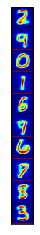

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [12]:
print(type(kmeans.cluster_centers_.T))
print(kmeans.cluster_centers_.T.shape)
A = display_network(kmeans.cluster_centers_.T, K, 1)

f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('a1.png', bbox_inches='tight')


# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())

# map the normalized data to colors
# image is now RGBA (512x512x4) 
image = cmap(norm(A))

# scipy.misc.imsave('aa.png', image)
imageio.imsave('aa.png', image)

In [13]:
print(type(pred_label))
print(pred_label.shape)
print(type(X0))

<class 'numpy.ndarray'>
(1000,)
<class 'numpy.ndarray'>


In [15]:
N0 = 20;
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))

for k in range(K):
    Xk = X0[pred_label == k, :]

    center_k = [kmeans.cluster_centers_[k]]
    neigh = NearestNeighbors().fit(Xk)
    dist, nearest_id  = neigh.kneighbors(center_k, N0)
    
    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

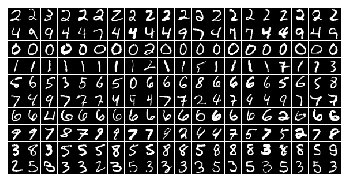

In [16]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()